# Cleaning Data

In [1]:
import numpy as np # linear algebra
import pandas as pd

ratings = pd.read_csv('ratings.csv')

ratings= ratings.drop(['userId', 'timestamp'], axis=1)

ratings= ratings.groupby(ratings['movieId']).aggregate({'rating': 'mean'})
ratings.head()

,rating
movieId,
1,3.895833
2,3.223653
3,3.166008
4,2.925532
5,3.039583


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import json

#movies data 
movies = pd.read_csv('movies_metadata.csv')

drop_movies = ["homepage", "poster_path", "video", "imdb_id", "overview", "original_title", 
           "spoken_languages", "tagline","belongs_to_collection","production_companies","production_countries"]

movies = movies.drop(drop_movies, axis=1) # Remove unnecessary columns containing "drop_movies" list
movies = movies.drop_duplicates(keep='first') # Remove if there is duplicate
movies.dropna(inplace=True) # Remove null columns

movies["id"] =pd.to_numeric(movies['id'], errors='coerce', downcast="integer")  #Since identity types are objective, we convert them to an integer.

**Json to Arr for genres json**

In [3]:
def json_to_arr(cell, wanted = "name"): 
    cell = literal_eval(cell)
    if cell == [] or (isinstance(cell, float) and cell.isna()):
        return np.nan
    result = []
    counter = 0
    for element in cell:
        if counter < 3:
            result.append(element[wanted])
            counter += 1
        else:
            break
    return result[:3]

In [4]:
movies[['genres']] = movies[['genres']].applymap(json_to_arr)
movies.head(10)

,adult,budget,genres,id,original_language,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count
0,False,30000000,"[Animation, Comedy, Family]",862,en,21.946943,1995-10-30,373554033.0,81.0,Released,Toy Story,7.7,5415.0
1,False,65000000,"[Adventure, Fantasy, Family]",8844,en,17.015539,1995-12-15,262797249.0,104.0,Released,Jumanji,6.9,2413.0
2,False,0,"[Romance, Comedy]",15602,en,11.712900,1995-12-22,0.0,101.0,Released,Grumpier Old Men,6.5,92.0
3,False,16000000,"[Comedy, Drama, Romance]",31357,en,3.859495,1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0
4,False,0,[Comedy],11862,en,8.387519,1995-02-10,76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0
5,False,60000000,"[Action, Crime, Drama]",949,en,17.924927,1995-12-15,187436818.0,170.0,Released,Heat,7.7,1886.0
6,False,58000000,"[Comedy, Romance]",11860,en,6.677277,1995-12-15,0.0,127.0,Released,Sabrina,6.2,141.0
7,False,0,"[Action, Adventure, Drama]",45325,en,2.561161,1995-12-22,0.0,97.0,Released,Tom and Huck,5.4,45.0
8,False,35000000,"[Action, Adventure, Thriller]",9091,en,5.231580,1995-12-22,64350171.0,106.0,Released,Sudden Death,5.5,174.0
9,False,58000000,"[Adventure, Action, Thriller]",710,en,14.686036,1995-11-16,352194034.0,130.0,Released,GoldenEye,6.6,1194.0


**List Counter**

In [5]:
def list_counter(col, limiter = 9999, log = True):
    result = dict()
    for cell in col:
        if isinstance(cell, float):
            continue
        for element in cell:
            if element in result:
                result[element] += 1
            else:
                result[element] = 1
    if log:
        print("Size of words:", len(result))
    result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1], reverse=True)}
    if log:
        print("Sorted result is:")
    counter = 1
    sum_selected = 0
    total_selected = 0
    rest = 0
    returned = []
    for i in result: 
        if counter > limiter:
            total_selected += result[i]
        else:
            counter += 1
            sum_selected += result[i]
            total_selected += result[i]
            if log:
                print(result[i], " - ", i) 
            returned.append([i, result[i]])
    if log:
        print("Covered:", sum_selected, "out of", total_selected, "\n")
    return returned

In [6]:
genres_occur = list_counter(movies["genres"].values, log=False)

**fill nan with list**

In [7]:
def fill_na_with_list(cell, data):
    if isinstance(cell, float):
        return data
    else:
        return cell

In [8]:
movies[['genres']] = movies[['genres']].applymap(lambda row:
                                        fill_na_with_list(row, [genres_occur[0][0]]))

In [9]:
vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int') #vote count
vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int') #vote avarege for genres avarege

# Genres Average and movies Average

**Film type Weighted rating function**

In [10]:
C = vote_averages.mean()
m = vote_counts.quantile(0.75)
def weighted_rating(data):
    v = data['vote_count'] + 1 
    R = data['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

In [11]:
movies['weighted_rating'] = movies.apply(weighted_rating, axis=1)  #new columns weighter rating
movies.head(10)

,adult,budget,genres,id,original_language,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count,weighted_rating
0,False,30000000,"[Animation, Comedy, Family]",862,en,21.946943,1995-10-30,373554033.0,81.0,Released,Toy Story,7.7,5415.0,7.665002
1,False,65000000,"[Adventure, Fantasy, Family]",8844,en,17.015539,1995-12-15,262797249.0,104.0,Released,Jumanji,6.9,2413.0,6.853418
2,False,0,"[Romance, Comedy]",15602,en,11.712900,1995-12-22,0.0,101.0,Released,Grumpier Old Men,6.5,92.0,6.080457
3,False,16000000,"[Comedy, Drama, Romance]",31357,en,3.859495,1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0,5.785585
4,False,0,[Comedy],11862,en,8.387519,1995-02-10,76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0,5.689316
5,False,60000000,"[Action, Crime, Drama]",949,en,17.924927,1995-12-15,187436818.0,170.0,Released,Heat,7.7,1886.0,7.602687
6,False,58000000,"[Comedy, Romance]",11860,en,6.677277,1995-12-15,0.0,127.0,Released,Sabrina,6.2,141.0,5.987451
7,False,0,"[Action, Adventure, Drama]",45325,en,2.561161,1995-12-22,0.0,97.0,Released,Tom and Huck,5.4,45.0,5.581745
8,False,35000000,"[Action, Adventure, Thriller]",9091,en,5.231580,1995-12-22,64350171.0,106.0,Released,Sudden Death,5.5,174.0,5.559726
9,False,58000000,"[Adventure, Action, Thriller]",710,en,14.686036,1995-11-16,352194034.0,130.0,Released,GoldenEye,6.6,1194.0,6.531493


In [13]:
q_movies = movies.sort_values('weighted_rating', ascending = False)

In [14]:
q_movies[['title', 'vote_count', 'vote_average', 'weighted_rating']].head(20)

,title,vote_count,vote_average,weighted_rating
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.669519
314,The Shawshank Redemption,8358.0,8.5,8.468196
834,The Godfather,6024.0,8.5,8.456066
12481,The Dark Knight,12269.0,8.3,8.279792
2843,Fight Club,9678.0,8.3,8.274435
292,Pulp Fiction,8670.0,8.3,8.271495
522,Schindler's List,4436.0,8.3,8.244865
5481,Spirited Away,3968.0,8.3,8.238515
2211,Life Is Beautiful,3643.0,8.3,8.233171
1178,The Godfather: Part II,3418.0,8.3,8.228892


**Movie Analys show**

In [15]:
import plotly.express as px
data = q_movies[['title', 'vote_count', 'vote_average', 'weighted_rating']].head(20)

fig = px.bar(data, x = 'title', y = 'weighted_rating',
             hover_data = ['vote_count', 'vote_average'], color='weighted_rating',
             labels = {'weighted_rating':'weighted_rating', 'title': 'Movie Name'}, height = 400,
             title = 'Movie rating disturbition')
fig.show()

According to our analysis, we can say that the most preferred and rated film is Dilwale.

**Movie Rating**

In [16]:
df_genres = movies[["title","genres","weighted_rating"]]  #we take the necessary places
genres = list_counter(df_genres["genres"].values, log=False)
genres

[['Drama', 8442],
 ['Comedy', 5139],
 ['Romance', 2870],
 ['Action', 2719],
 ['Thriller', 2406],
 ['Crime', 1728],
 ['Horror', 1542],
 ['Adventure', 1519],
 ['Science Fiction', 908],
 ['Family', 869],
 ['Mystery', 852],
 ['Fantasy', 821],
 ['Documentary', 784],
 ['Music', 637],
 ['History', 542],
 ['War', 498],
 ['Animation', 450],
 ['Foreign', 414],
 ['Western', 357],
 ['TV Movie', 68]]

**List To Column**

In [17]:
def list_to_col(data, col_name, col_list, limiter = 9999):
    counter = 0
    selected_items = set()
    for item in col_list:
        if counter >= limiter:
            break
        item = item[0]
        data[item] = 0
        selected_items.add(item)
        counter += 1
    
    for index, row in data.iterrows():
        for item in row[col_name]:  
            if item in selected_items:
                data.at[index, item] = 1
    data.drop([col_name], axis=1, inplace=True)
    return data

In [18]:
df_genres = list_to_col(df_genres, "genres", genres)
df_genres

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,weighted_rating,Drama,Comedy,Romance,Action,Thriller,Crime,Horror,Adventure,Science Fiction,Family,Mystery,Fantasy,Documentary,Music,History,War,Animation,Foreign,Western,TV Movie
0,Toy Story,7.665002,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,Jumanji,6.853418,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
2,Grumpier Old Men,6.080457,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale,5.785585,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Father of the Bride Part II,5.689316,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15501,Snake-Crane Secret,5.717794,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15502,Yumeji,5.656260,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15503,Zigeunerweisen,5.739295,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
15504,The Kids Are All Right,6.370273,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Average dataset builder**

In [20]:
def binary_mean_dataset_generator(data, col_list, limiter = 9999):
    counter = 0
    items = []
    for item in col_list:
        if counter >= limiter:
            break
        items.append(item[0])
        counter += 1
    rows = []
    for item in items:
        value = data[data[item] == 1].mean()
        rows.append([item, value[0]])
    
    df_genres_means = pd.DataFrame(rows, columns=["genres", "rating"])
    return df_genres_means

In [21]:
df_means_genres = binary_mean_dataset_generator(df_genres, genres) #new df_means average

**Film genres analysis according to their ratings**

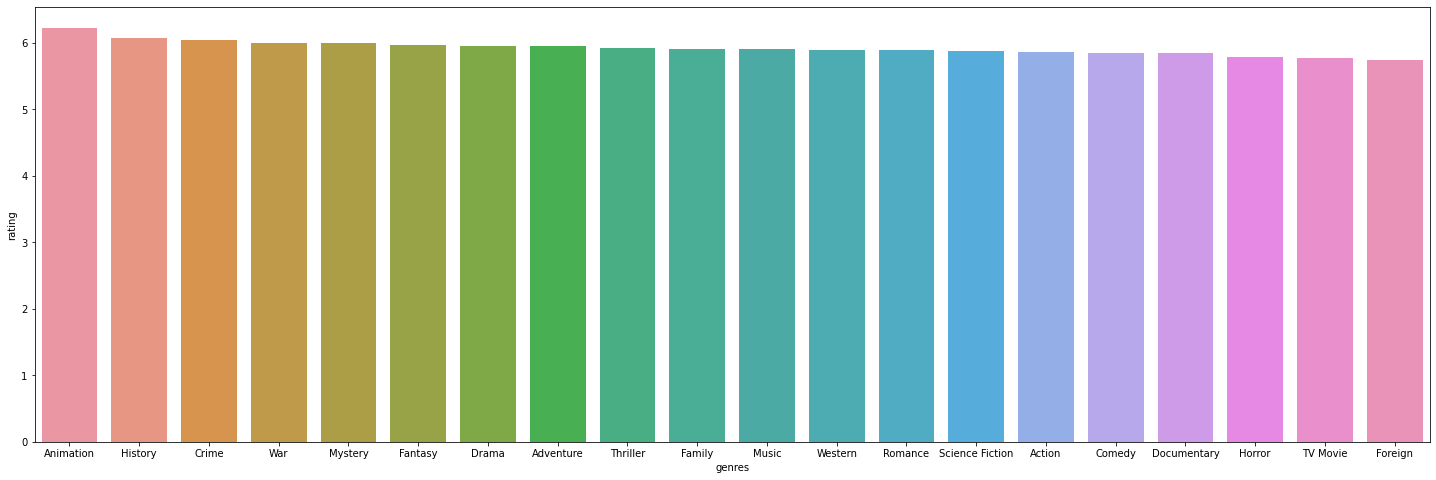

In [22]:
plt.figure(figsize=(25,8))
sns.barplot(x='genres', y='rating', data=df_means_genres,order=df_means_genres.sort_values('rating',ascending = False).genres)
plt.show()